![logo](../img/LogoLine_horizon_C3S.png)

# Ice sheet surface elevation change rates
 
By Sebastian B. Simonsen, DTU Space, ssim@space.dtu.dk

## About

This tutorial will demonstrate how to plot a map of the average surface elevation change rates across the Greenland or Antarctic ice sheets, using data from the Copernicus Climate Change Service (C3S). 

It should be noted that the Antarctica product is not updated since February 2023, hence are the folowing code provided using the version 3 of the CDS data. Newer dataversion are avilable for Greenland.

It will show you how to download data from the C3S Climate Data Store (CDS), calculate average change rates over a selectable period, and display the results.

## Prepare your environment

To download data from the CDS, you must complete three steps;
1. Register for free with the CDS at https://cds.climate.copernicus.eu/#!/home
2. Set up the CDS Application Program Interface (API), as described at https://cds.climate.copernicus.eu/api-how-to
3. Agree to the dataset terms of use - if you have not already done so you will be directed to the correct webpage the first time you try to download data. Accept the terms and conditions, and re-run the downloading code.

## Import libraries

The data is stored in netCDF4 files. To work with them, several libraries are needed. These are used to retrieve the data, unpack it, run calculations and plot the results.

In [7]:
# CDS API
import cdsapi

# File handling
import shutil
import glob
import os

# Calculations
import numpy as np
import xarray as xr

# Mapping
import cartopy.crs as ccrs

# Plotting
import matplotlib.pyplot as plt

## Download data

Select the ice sheet of interest and retrieve the dataset. An example of how to retrieve the data is given on the CDS, under 'Show API request' on the dataset's webpage at https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-ice-sheet-elevation-change?tab=form

The dataset comes in a zip file, and may include several files. Only the most recent is necessary - this contains all of the data in previous files, plus the latest update.  

In [8]:
# Set ice_sheet to the desired ice sheet, either 'antarctica' or 'greenland'
# This will be used to select data, and later to set up plot defaults

ice_sheet = 'greenland'

try:
    
    # Download data from the CDS

    c = cdsapi.Client()

    c.retrieve(
        'satellite-ice-sheet-elevation-change',
        {
            'domain': ice_sheet,
            'climate_data_record_type': 'icdr',
            'version': '3_0',
            'variable': 'all',
            'format': 'zip',
        },
        'download.zip')

    # Unpack the zip file and remove the zipped data

    shutil.unpack_archive('download.zip', '.')
    os.remove('download.zip')
except:
    pass

# List the files contained and select the latest netCDF (.nc) file. Print its filename

list_of_files = glob.glob('*.nc') # * means all if need specific format then *.nc
latest_file = max(list_of_files, key=os.path.getctime)
print('In the following you are seeing the data from: \n'+latest_file)

2023-10-31 09:48:23,489 INFO Welcome to the CDS
2023-10-31 09:48:23,490 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-ice-sheet-elevation-change
2023-10-31 09:48:23,617 INFO Request is completed
2023-10-31 09:48:23,619 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data6/dataset-satellite-ice-sheet-elevation-change-4c0011a9-bb7c-4efb-9d37-cb8b5789d6b0.zip to download.zip (17.7M)
2023-10-31 09:48:25,967 INFO Download rate 7.5M/s   


In the following you are seeing the data from: 
C3S_GrIS_RA_SEC_25km_vers3_2023-09-16.nc


## Examine the data

Open the data file and list its contents. These include descriptive comments.

In [9]:
# Open the NetCDF file

ds = xr.open_dataset(latest_file)

# Print contents list

print('The data file contains the following:')
print(ds)

The data file contains the following:
<xarray.Dataset>
Dimensions:          (x: 65, y: 123, t: 375)
Coordinates:
  * x                (x) float32 -7.393e+05 -7.143e+05 ... 8.357e+05 8.607e+05
  * y                (y) float32 -3.478e+06 -3.453e+06 ... -4.531e+05 -4.281e+05
Dimensions without coordinates: t
Data variables: (12/16)
    time             (t) datetime64[ns] ...
    start_time       (t) datetime64[ns] ...
    end_time         (t) datetime64[ns] ...
    grid_projection  |S1 ...
    lat              (y, x) float32 ...
    lon              (y, x) float32 ...
    ...               ...
    dhdt_stabil      (y, x, t) float32 ...
    dhdt_ok          (y, x, t) int8 ...
    dist             (y, x, t) float32 ...
    land_mask        (y, x) int8 ...
    high_slope       (y, x) int8 ...
    area             (y, x) float32 ...
Attributes: (12/32)
    Title:                Surface Elevation change of the Greenland ice sheet...
    institution:          Copernicus Climate Change Service, 

This NetCDF file contains data related to surface elevation change of the ice sheet. Here's a breakdown of the file structure and its contents:

**Dimensions:** 
- `x`: Projected longitudinal coordinates with values ranging from approximately -739,300 to 860,700 (for Greenland).
- `y`: Projected latitudinal coordinates with values ranging from approximately -3,478,000 to -428,100 (for Greenland).
- `t`: Time coordinates.

**Data Variables:** 
- Among others, the elevation change is represented in the variable `dhdt`.

Additional meta-data is included in the file's attributes.


## Calculate averages and plot

The ice sheets are split into 25km by 25km cells. In each cell is a series of surface elevation change rates (called 'sec' for Antarctica or 'dhdt' for Greenland), at times given by the 'time' array. Take the average of the rates for your chosen time period. Plot using a mapping library.

### Why is data missing from the South Pole? 

The change rates series may not have a value at every time - a blank (represented by not-a-number or 'NaN') is left where measurements could not be made or were of low quality. A special case is the interior of the Antarctic ice sheet, below 81.5&deg;S. Five of the six satellites used to make the dataset could not see into this region. All the data there came from CryoSat-2, which has a more tilted orbit. Even CryoSat-2 can only see down to 88&deg;S and so there is a circular region around the South Pole which never contains data. 

This has a further consequence. In the simple averaging calculation below, data from the region seen only by CryoSat-2 will only be available for the CryoSat-2 mission period, which began in 2010, even if the start of the averaging period is before that.

### What would be a good colour palette for the plot?

Many published plots, such as the one on this page https://www.cnet.com/science/climate/nasa-study-reveals-decades-of-antarctic-ice-loss-that-went-under-the-radar/plots, use a red-to-blue colour scale, where red represents ice loss, blue represents gain and the white centre represents no change. This works well if the data range is centred on zero, but looks misleading when it is not. The scale used in the example code, a red-to-green-to-blue scale, is a colourblind accessible alternative.

If the data range is not centred on zero, then the python 'viridis' colour scale, which is also colourblind accessible, is an example of a better choice.

/Users/ssim/miniconda3/envs/py38/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/ssim/miniconda3/envs/py38/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


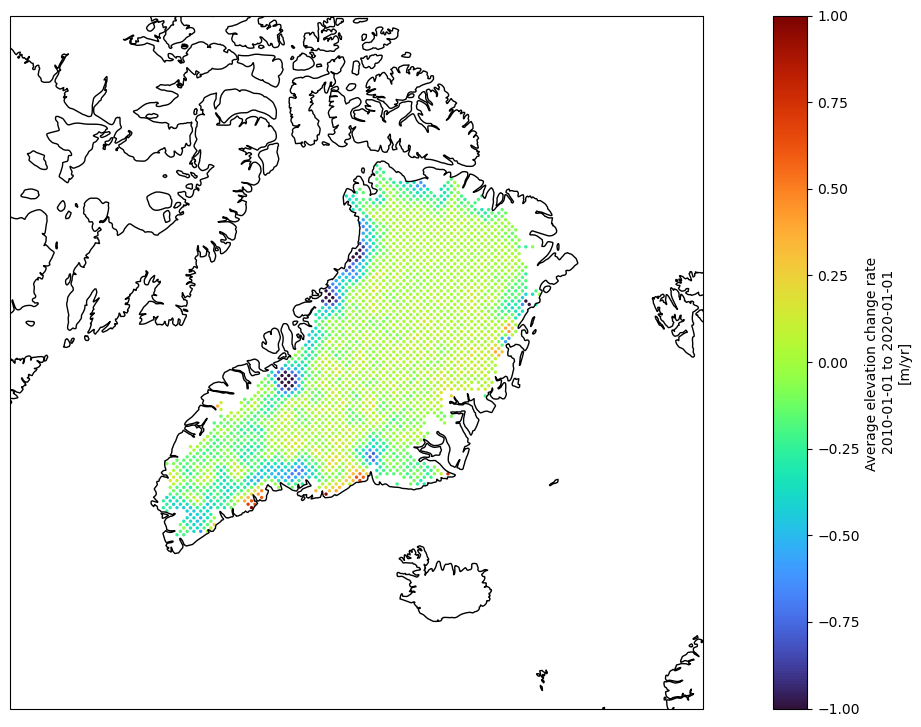

In [10]:
# Use start_time and end_time to define the averaging time range. Here it's a 10 year period starting in 2010. 

start_time = np.datetime64('2010-01-01 00:00:00')
end_time   = np.datetime64('2020-01-01 00:00:00')
Tbool = (ds['time']>= start_time) & (ds['time']< end_time)

# Read in data from the selected ice sheet and calculate the mean surface elevation change rate over the time range. 
# The variable names inside the netCDF files differ between ice sheets. Also specific to the selected ice sheet are 
# the map projection and the longitude and latitude boundaries, so set them up here.

if 'green' in ice_sheet:

    lon = ds['lon']
    lat = ds['lat']
    
    dhdt_ave = np.mean(ds['dhdt'][:,:,Tbool], axis=2)

    projection = ccrs.NorthPolarStereo()
    #ext = [-73, -12, 59, 83]    # map boundaries, in degrees, [east, west, south, north]
    
else:

    lon = ds['longitude']
    lat = ds['latitude']
    
    dhdt_ave = np.mean(ds['sec'][:,:,Tbool], axis=2)

    projection = ccrs.SouthPolarStereo()
    #ext = [-180, 180, -90, -60]

# Create a new figure

fig = plt.figure(figsize=(18,9))

# Add a new subplot to the figure with the projection defined above

ax = plt.axes(projection=projection)

# Set the extent of the map to the longitude and latitude range defined above

#ax.set_extent(ext, crs=ccrs.PlateCarree())

# Add the coastlines to the map

ax.coastlines(resolution='50m')

# Plot the data on the map using the longitude and latitude variables. Customise the plot settings.

vmin=-1.0         # Datapoints below this value will be set to the bottom of the colour range
vmax=1.0          # Datapoints above this value will be set to the top of the colour range
marker_size=2     # The size of the dots used to mark each datapoint
cmap='turbo'      # Alternatively use 'bwr_r' for red to blue if the data range is centred on zero, otherwise try 'viridis'
cs = ax.scatter(lon, lat, c=dhdt_ave, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, s=marker_size, cmap=cmap)

# Add a colorbar to the map

cbar = plt.colorbar(cs)

# Add a label to the colorbar, giving the selected time range and the data units

cbar.set_label('Average elevation change rate \n'+str(start_time)[:10]+ ' to ' +str(end_time)[:10]+ '\n[m/yr]')

# Display the plot

plt.show()